<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-scraped-data" data-toc-modified-id="Import-scraped-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import scraped data</a></span></li><li><span><a href="#Raw-data-cleaning" data-toc-modified-id="Raw-data-cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Raw data cleaning</a></span></li><li><span><a href="#Parole-Data" data-toc-modified-id="Parole-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parole Data</a></span></li></ul></div>

In [1]:
"""
STATE: AL
POLICY: Parole Grant Rates
VERSION: V1
DATA SOURCE: AL public DOC inmate data and AL reports
DATA QUALITY: medium-low
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: October 2022
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


# %run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = 100
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("max_seq_items", 100)
pd.set_option("display.width", 100)

In [2]:
import sys
import os
sys.path.insert(0, os.path.relpath('../'))

from super_simulation.time_converter import (
    TimeConverter,
)
from utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from utils.spark_preprocessing_utils import (
    convert_dates,
)
# from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

# Get the simulation tag from the model inputs config
yaml_file_path = "al_gun_minimums_v1.yaml"

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)

### Import scraped data

In [3]:
inc_time_span_col = [
    "Total_Term",
    "Time_Served",
    "Good_Time_Received",
    "Good_Time_Revoked",
]
sen_time_span_col = ["Term"]
inc_date_col = ["Admit_Date", "Min_Release_Date", "Parole_Consideration_Date", "run_id"]
sen_date_col = ["Sentenced", "run_id"]

### Raw data cleaning

In [4]:
persons = pd.read_csv('../state/AL/al_persons_scraped.csv').drop(columns='collection_id')
incarcerations = pd.read_csv('../state/AL/al_incarcerations_scraped.csv').drop(columns='collection_id')
sentences = pd.read_csv('../state/AL/al_sentences_scraped.csv').drop(columns='collection_id')

C:\Users\isaac\AppData\Local\Temp\ipykernel_16616\1873340900.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  incarcerations = pd.read_csv('../state/AL/al_incarcerations_scraped.csv').drop(columns='collection_id')


In [5]:
incarcerations.head(100)

,Unnamed: 0,SUF,Admit_Date,Total_Term,Time_Served,Jail_Credit,Good_Time_Received,Good_Time_Revoked,Min_Release_Date,Parole_Consideration_Date,Parole_Status,most_recent,AIS,incarceration_id,run_id
0,0,0,05/03/1977,0Y 0M 0D,10Y 4M 5D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z350,Z350-0,2023-05-05 15:53:15.991829
1,1,0,09/07/1977,0Y 0M 0D,32Y 8M 18D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z355,Z355-0,2023-05-05 15:53:15.991829
2,2,0,09/09/1977,0Y 0M 0D,22Y 0M 28D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z357,Z357-0,2023-05-05 15:53:15.991829
3,3,0,11/01/1977,0Y 0M 0D,17Y 2M 8D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z360,Z360-0,2023-05-05 15:53:15.991829
4,4,0,11/01/1977,0Y 0M 0D,27Y 6M 21D,1947,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z361,Z361-0,2023-05-05 15:53:15.991829
5,5,0,12/14/1977,0Y 0M 0D,18Y 2M 0D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z362,Z362-0,2023-05-05 15:53:15.991829
6,6,0,03/13/1978,0Y 0M 0D,8Y 0M 4D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z366,Z366-0,2023-05-05 15:53:15.991829
7,7,0,03/13/1978,0Y 0M 0D,11Y 11M 9D,139,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z368,Z368-0,2023-05-05 15:53:15.991829
8,8,0,07/07/1978,0Y 0M 0D,14Y 4M 14D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z378,Z378-0,2023-05-05 15:53:15.991829
9,9,0,10/27/1978,0Y 0M 0D,7Y 6M 4D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,Z382,Z382-0,2023-05-05 15:53:15.991829


In [43]:
incarcerations.AIS = incarcerations.AIS.str.zfill(8)
sentences.AIS = sentences.AIS.str.zfill(8)

incarcerations.Parole_Consideration_Date = (
    incarcerations.Parole_Consideration_Date.mask(
        incarcerations.Parole_Consideration_Date == "nan", None
    )
)
incarcerations.Min_Release_Date = incarcerations.Min_Release_Date.mask(
    (incarcerations.Min_Release_Date == "nan"), None
)

gun_keywords = ["PISTOL", "GUN", "RIFLE", "SHTGN"]
sentences["is_firearm"] = sentences.Offense.str.contains("|".join(gun_keywords))

In [7]:
def parse_time_span(s: pd.Series) -> pd.Series:
    df = (
        pd.concat(
            [
                s.str.extract("(?P<year>\d*)Y\s*(?P<month>\d*)M\s*(?P<day>\d*)D"),
                s.str.extract("(?P<days>\d*) Days"),
            ],
            axis=1,
        )
        .fillna(0)
        .astype(int, errors="ignore")
    )
    df["sentence"] = df.year + df.month / 12 + df.day / 365.25
    return df.sentence.mask(df.sentence == 0, df.days / 365.25)

In [8]:
for col in inc_time_span_col:
    incarcerations[col.lower()] = parse_time_span(incarcerations[col])
for col in sen_time_span_col:
    sentences[col.lower()] = parse_time_span(sentences[col])

In [9]:
def parse_date(s: pd.Series) -> pd.Series:
    df = pd.DataFrame(s)
    df["date"] = pd.to_datetime(df[s.name], errors="coerce")
    df["date_adj"] = df.date.mask(
        df.date.isna() & (df[s.name] != "nan"), pd.Timestamp.max
    )
    return df.date_adj

In [10]:
for col in inc_date_col:
    incarcerations[col.lower()] = parse_date(incarcerations[col])
for col in sen_date_col:
    sentences[col.lower()] = parse_date(sentences[col])

In [11]:
incarcerations.head(2)

,Unnamed: 0,SUF,Admit_Date,Total_Term,Time_Served,Jail_Credit,Good_Time_Received,Good_Time_Revoked,Min_Release_Date,Parole_Consideration_Date,Parole_Status,most_recent,AIS,incarceration_id,run_id,total_term,time_served,good_time_received,good_time_revoked,admit_date,min_release_date,parole_consideration_date
0,0,0,05/03/1977,0Y 0M 0D,10Y 4M 5D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z350,Z350-0,2023-05-05 15:53:15.991829,0.0,10.347023,0.0,0.0,1977-05-03,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807
1,1,0,09/07/1977,0Y 0M 0D,32Y 8M 18D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z355,Z355-0,2023-05-05 15:53:15.991829,0.0,32.715948,0.0,0.0,1977-09-07,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807


In [12]:
sentences.head(2)

,Unnamed: 0,incarceration_id,Case_Number,Sentenced,Offense,Term,Type,Commit_County,AIS,run_id,is_firearm,term,sentenced
0,0,319206-R,CC2016-000034,09/09/2019,MURDER,0Y *M 0D,Concurrent,BIBB,00319206,2023-05-05 15:53:15.991829,False,0.0,2019-09-09
1,1,332541-S,CC2022-000029,01/26/2023,RAPE I,0Y *M 0D,Consecutive,CHILTON,00332541,2023-05-05 15:53:15.991829,False,0.0,2023-01-26


In [13]:
incarcerations['sex_offender'] = incarcerations.SUF=='S'

In [14]:
incarcerations.groupby('AIS').sex_offender.sum().max()

1

In [15]:
felony_mapping = pd.read_csv(
    '../state/AL/felony_mapping.csv'
).fillna(False)

In [16]:
felony_mapping = felony_mapping.rename(columns={"Unnamed: 0": "Offense"})

In [17]:
felony_mapping[["involves_gun_possession", "involves_discharging_a_gun", "is_a_felony_dangerous_to_human_life"]] = felony_mapping[["involves_gun_possession", "involves_discharging_a_gun", "is_a_felony_dangerous_to_human_life"]].astype(bool)

In [18]:
felony_mapping.head(100)

,Offense,count,involves_gun_possession,involves_discharging_a_gun,is_a_felony_dangerous_to_human_life
0,BURGLARY III,11015,False,False,False
1,POSS CONTROL SUBSTANCE,7237,False,False,False
2,ROBBERY I,7208,False,False,True
3,POSS/REC CONTROL SUBSTANCE - CLASSD,6589,False,False,False
4,THEFT OF PROPERTY I,5937,False,False,False
5,THEFT OF PROPERTY II,5650,False,False,False
6,MURDER,5305,False,False,True
7,DIST CONTROL SUBSTANCE,5179,False,False,False
8,UNLAW BREAKING AND ENTERING VEHICLE,4137,False,False,False
9,CRIM POSS FORGED INSTR II,2593,False,False,False


In [19]:
sentences_with_mapping = pd.merge(
    sentences,
    felony_mapping,
    how='inner',
    on='Offense'
)
inc = pd.merge(
    incarcerations,
    sentences_with_mapping,
    how='inner',
    on=['incarceration_id','AIS','run_id']
)

In [20]:
# fel = inc[inc.is_a_felony_dangerous_to_human_life &
#           (inc.admit_date > '2012-01-01')]
# fel.shape

In [21]:
fel = inc[inc.is_a_felony_dangerous_to_human_life]
fel.shape

(9948, 37)

In [22]:
# inc.total_term.clip(upper = 120, inplace=True)

In [23]:
fel = fel[fel.admit_date != fel.admit_date.max()]

<AxesSubplot: >

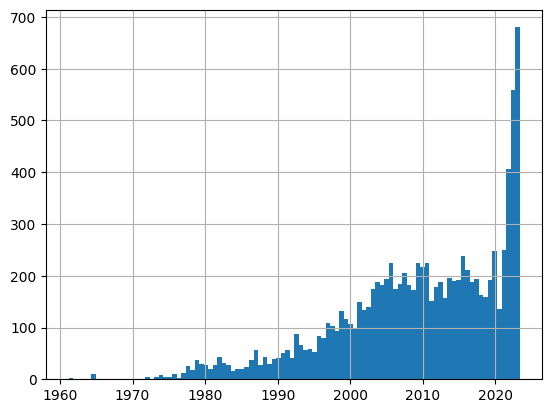

In [24]:
fel.admit_date.hist(bins=100)

<AxesSubplot: >

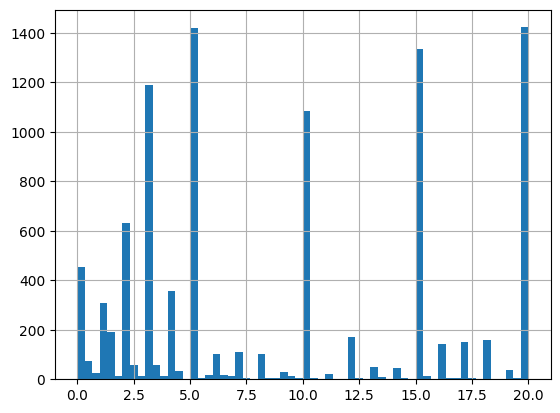

In [25]:
fel.total_term.hist(bins=60)

In [26]:
fel.dtypes

Unnamed: 0_x                                    int64
SUF                                            object
Admit_Date                                     object
Total_Term                                     object
Time_Served                                    object
Jail_Credit                                     int64
Good_Time_Received                             object
Good_Time_Revoked                              object
Min_Release_Date                               object
Parole_Consideration_Date                      object
Parole_Status                                  object
most_recent                                      bool
AIS                                            object
incarceration_id                               object
run_id                                 datetime64[ns]
total_term                                    float64
time_served                                   float64
good_time_received                            float64
good_time_revoked           

In [27]:
fel[["incarceration_id",'AIS','run_id']].value_counts()

incarceration_id  AIS       run_id                    
Z816-0            0000Z816  2023-05-05 15:53:15.991829    15
Z722-0            0000Z722  2023-05-05 15:53:15.991829    13
332225-S          00332225  2023-05-05 15:53:15.991829    13
217794-0          00217794  2023-05-05 15:53:15.991829    12
91758-0           00091758  2023-05-05 15:53:15.991829    11
                                                          ..
226834-B          00226834  2023-05-05 15:53:15.991829     1
226782-0          00226782  2023-05-05 15:53:15.991829     1
226711-B          00226711  2023-05-05 15:53:15.991829     1
226696-0          00226696  2023-05-05 15:53:15.991829     1
Z823-0            0000Z823  2023-05-05 15:53:15.991829     1
Length: 7370, dtype: int64

In [28]:
def combine_terms(incarcerations):
    concurrents = incarcerations[incarcerations.Type == 'Concurrent']
    if concurrents.empty:
        combined = incarcerations.iloc[0]
        combined.total_term = incarcerations.total_term.sum()
    else:
        combined = concurrents.iloc[0]
        combined.total_term += (incarcerations.total_term * incarcerations.Type.map({'Concurrent': 0, 'Consecutive': 1})).sum()
    return combined

fel_collapsed_incarcerations = fel.groupby("incarceration_id").apply(combine_terms)

In [29]:
fel_collapsed_incarcerations.head()

,Unnamed: 0_x,SUF,Admit_Date,Total_Term,Time_Served,Jail_Credit,Good_Time_Received,Good_Time_Revoked,Min_Release_Date,Parole_Consideration_Date,Parole_Status,most_recent,AIS,incarceration_id,run_id,total_term,time_served,good_time_received,good_time_revoked,admit_date,min_release_date,parole_consideration_date,sex_offender,Unnamed: 0_y,Case_Number,Sentenced,Offense,Term,Type,Commit_County,is_firearm,term,sentenced,count,involves_gun_possession,involves_discharging_a_gun,is_a_felony_dangerous_to_human_life
incarceration_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101907-B,1464,B,05/07/1975,1Y 0M 0D,0Y 11M 28D,72,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,False,00101907,101907-B,2023-05-05 17:43:14.033905,1.0,0.993326,0.000000,0.000000,1975-05-07,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,64629,CC1975-032863,04/18/1975,BURGLARY II (OLD CODE/PRIOR JAN 80),10Y 0M 0D,Concurrent,MOBILE,False,10.0,1975-04-18,255,False,False,True
102626-0,7072,0,05/03/1971,3Y 0M 0D,1Y 0M 19D,0,1Y 1M 6D,0Y 0M 0D,03/26/1973,05/01/1980,NO HEARING,False,00102626,102626-0,2023-05-05 15:53:15.991829,3.0,1.052019,1.099760,0.000000,1971-05-03,1973-03-26 00:00:00.000000000,1980-05-01 00:00:00.000000000,False,20697,*CR1971-010101,05/03/1971,BURGLARY II (OLD CODE/PRIOR JAN 80),3Y 0M 0D,Consecutive,HOUSTON,False,3.0,1971-05-03,255,False,False,True
102626-A,16205,A,06/20/1977,9Y 0M 0D,2Y 0M 25D,35,3Y 10M 24D,0Y 0M 0D,06/20/1982,NaN,NO HEARING,False,00102626,102626-A,2023-05-05 15:53:15.991829,9.0,2.068446,3.899042,0.000000,1977-06-20,1982-06-20 00:00:00.000000000,2262-04-11 23:47:16.854775807,False,41161,*CC1977-000146,06/20/1977,ASSAULT/INTENT MURDER,9Y 0M 0D,Consecutive,HOUSTON,False,9.0,1977-06-20,45,False,False,True
102855-A,23016,A,08/20/1979,10Y 0M 0D,3Y 9M 25D,341,6Y 4M 0D,0Y 2M 0D,06/04/1982,NaN,NO HEARING,False,00102855,102855-A,2023-05-05 15:53:15.991829,10.0,3.818446,6.333333,0.166667,1979-08-20,1982-06-04 00:00:00.000000000,2262-04-11 23:47:16.854775807,False,71671,CC1978-000569,07/16/1979,BURGLARY II (OLD CODE/PRIOR JAN 80),10Y 0M 0D,Consecutive,MONTGOMERY,False,10.0,1979-07-16,255,False,False,True
103769-A,16206,A,05/19/1977,9Y 0M 0D,2Y 10M 4D,219,6Y 1M 22D,0Y 0M 0D,08/17/1979,11/01/1978,NO HEARING,False,00103769,103769-A,2023-05-05 15:53:15.991829,9.0,2.844285,6.143566,0.000000,1977-05-19,1979-08-17 00:00:00.000000000,1978-11-01 00:00:00.000000000,False,41039,CC1977-000012,05/19/1977,ARSON I (OLD CODE/ < JAN 1980),9Y 0M 0D,Consecutive,LEE,False,9.0,1977-05-19,7,False,False,True


In [30]:
fel[(fel["incarceration_id"] == "332225-S")]

,Unnamed: 0_x,SUF,Admit_Date,Total_Term,Time_Served,Jail_Credit,Good_Time_Received,Good_Time_Revoked,Min_Release_Date,Parole_Consideration_Date,Parole_Status,most_recent,AIS,incarceration_id,run_id,total_term,time_served,good_time_received,good_time_revoked,admit_date,min_release_date,parole_consideration_date,sex_offender,Unnamed: 0_y,Case_Number,Sentenced,Offense,Term,Type,Commit_County,is_firearm,term,sentenced,count,involves_gun_possession,involves_discharging_a_gun,is_a_felony_dangerous_to_human_life
55901,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66906,CC2021-002066,12/09/2022,RAPE II,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,788,False,False,True
55902,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66907,CC2021-002067,12/09/2022,RAPE II,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,788,False,False,True
55903,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66904,CC2021-002056,12/09/2022,SODOMY II,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,397,False,False,True
55904,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66905,CC2021-002055,12/09/2022,SODOMY II,10Y 0M 0D,Consecutive,HOUSTON,False,10.0,2022-12-09,397,False,False,True
55905,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66909,CC2021-002058,12/09/2022,XMIT OBSCENE MATERIAL TO CHILD COMPUTER,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,68,False,False,True
55906,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66910,CC2021-002057,12/09/2022,XMIT OBSCENE MATERIAL TO CHILD COMPUTER,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,68,False,False,True
55907,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66911,CC2021-002059,12/09/2022,XMIT OBSCENE MATERIAL TO CHILD COMPUTER,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,68,False,False,True
55908,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66912,CC2021-002060,12/09/2022,XMIT OBSCENE MATERIAL TO CHILD COMPUTER,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,68,False,False,True
55909,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66913,CC2021-002061,12/09/2022,XMIT OBSCENE MATERIAL TO CHILD COMPUTER,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,68,False,False,True
55910,26026,S,12/09/2022,10Y 0M 0D,1Y 11M 7D,561,195 Days,0 Days,07/24/2026,02/01/2025,NO HEARING,True,00332225,332225-S,2023-05-05 15:53:15.991829,10.0,1.935832,0.533881,0.0,2022-12-09,2026-07-24,2025-02-01,True,66914,CC2021-002062,12/09/2022,XMIT OBSCENE MATERIAL TO CHILD COMPUTER,10Y 0M 0D,Concurrent,HOUSTON,False,10.0,2022-12-09,68,False,False,True


<AxesSubplot: >

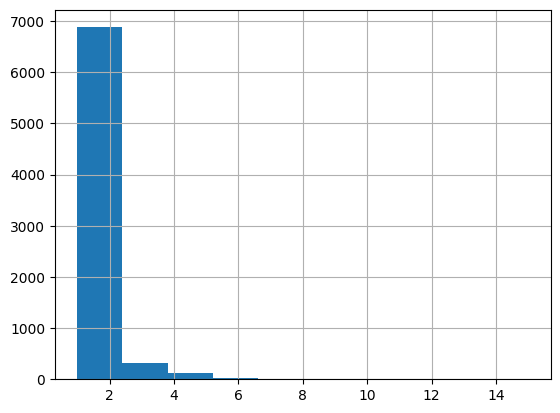

In [31]:
fel[["incarceration_id",'AIS','run_id']].value_counts().hist()

In [32]:
fel.head()

,Unnamed: 0_x,SUF,Admit_Date,Total_Term,Time_Served,Jail_Credit,Good_Time_Received,Good_Time_Revoked,Min_Release_Date,Parole_Consideration_Date,Parole_Status,most_recent,AIS,incarceration_id,run_id,total_term,time_served,good_time_received,good_time_revoked,admit_date,min_release_date,parole_consideration_date,sex_offender,Unnamed: 0_y,Case_Number,Sentenced,Offense,Term,Type,Commit_County,is_firearm,term,sentenced,count,involves_gun_possession,involves_discharging_a_gun,is_a_felony_dangerous_to_human_life
0,0,0,05/03/1977,0Y 0M 0D,10Y 4M 5D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z350,Z350-0,2023-05-05 15:53:15.991829,0.0,10.347023,0.0,0.0,1977-05-03,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,89,CC1977-000532,04/27/1977,MURDER,0Y 0M 0D,Consecutive,MOBILE,False,0.0,1977-04-27,5305,False,False,True
1,1,0,09/07/1977,0Y 0M 0D,32Y 8M 18D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z355,Z355-0,2023-05-05 15:53:15.991829,0.0,32.715948,0.0,0.0,1977-09-07,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,63,CC1977-000697,04/23/1987,AGGRAVATED MURDER,0Y 0M 0D,Consecutive,MOBILE,False,0.0,1987-04-23,14,False,False,True
2,2,0,09/09/1977,0Y 0M 0D,22Y 0M 28D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z357,Z357-0,2023-05-05 15:53:15.991829,0.0,22.076660,0.0,0.0,1977-09-09,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,94,CC1977-000051,05/20/1977,MURDER I,0Y 0M 0D,Consecutive,MONROE,False,0.0,1977-05-20,122,False,False,True
3,3,0,11/01/1977,0Y 0M 0D,17Y 2M 8D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z360,Z360-0,2023-05-05 15:53:15.991829,0.0,17.188569,0.0,0.0,1977-11-01,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,232,CC1977-000249,02/22/1980,MURDER,0Y 0M 0D,Consecutive,BESSEMER,False,0.0,1980-02-22,5305,False,False,True
4,4,0,11/01/1977,0Y 0M 0D,27Y 6M 21D,1947,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z361,Z361-0,2023-05-05 15:53:15.991829,0.0,27.557495,0.0,0.0,1977-11-01,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,387,CC1977-000180,05/14/1982,MURDER I,0Y 0M 0D,Consecutive,TUSCALOOSA,False,0.0,1982-05-14,122,False,False,True


### Parole Data

In [33]:
al_month_parole = pd.read_csv(
    "../state/AL/AL Parole Board Grant Rates - Monthly Reports.csv",
    comment="#",
    parse_dates=["Month"],
)

al_month_parole.category1.fillna(method="ffill", inplace=True)
al_month_parole.Month.fillna(method="ffill", inplace=True)
al_month_parole.category2 = al_month_parole.category2.mask(
    al_month_parole.category1 == "Totals", "Totals"
)

for col in ["Rate", "Rate - Guideline", "Conform"]:
    al_month_parole[col] = al_month_parole[col].str.rstrip("%").astype("float") / 100.0

al_grant_rates_by_month = al_month_parole[
    al_month_parole.category2.isin(["Totals", "Violent", "Non-violent"])
]
# hacky interpolation to fill missing report for Feb 2022
al_grant_rates_by_month = pd.concat(
    [
        al_grant_rates_by_month.Month,
        al_grant_rates_by_month.groupby("category2", group_keys=False).apply(
            lambda x: x[
                [
                    "category2",
                    "Decisions",
                    "Grant",
                    "Deny",
                    "Rate",
                    "Grant - Guideline",
                    "Deny - Guideline",
                    "Rate - Guideline",
                    "Conform",
                ]
            ].interpolate()
        ),
    ],
    axis=1,
)

al_grant_rates_by_month["Year"] = al_grant_rates_by_month.Month.dt.year
al_grant_rates_by_month_violent = al_grant_rates_by_month[
    (al_grant_rates_by_month.category2 == "Violent")
    & (al_grant_rates_by_month.Year == 2022)
][['Month','Decisions','Grant']]

In [34]:
al_grant_rates_by_month_violent.Grant.sum()/al_grant_rates_by_month_violent.Decisions.sum()

0.04291845493562232

In [35]:
# none of the above
# firearm possession or brandishing
# discharged
# ignoring repeats...for now
# take max of these 

disag = fel_collapsed_incarcerations

In [36]:
disag.head()

,Unnamed: 0_x,SUF,Admit_Date,Total_Term,Time_Served,Jail_Credit,Good_Time_Received,Good_Time_Revoked,Min_Release_Date,Parole_Consideration_Date,Parole_Status,most_recent,AIS,incarceration_id,run_id,total_term,time_served,good_time_received,good_time_revoked,admit_date,min_release_date,parole_consideration_date,sex_offender,Unnamed: 0_y,Case_Number,Sentenced,Offense,Term,Type,Commit_County,is_firearm,term,sentenced,count,involves_gun_possession,involves_discharging_a_gun,is_a_felony_dangerous_to_human_life
incarceration_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101907-B,1464,B,05/07/1975,1Y 0M 0D,0Y 11M 28D,72,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,False,00101907,101907-B,2023-05-05 17:43:14.033905,1.0,0.993326,0.000000,0.000000,1975-05-07,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,64629,CC1975-032863,04/18/1975,BURGLARY II (OLD CODE/PRIOR JAN 80),10Y 0M 0D,Concurrent,MOBILE,False,10.0,1975-04-18,255,False,False,True
102626-0,7072,0,05/03/1971,3Y 0M 0D,1Y 0M 19D,0,1Y 1M 6D,0Y 0M 0D,03/26/1973,05/01/1980,NO HEARING,False,00102626,102626-0,2023-05-05 15:53:15.991829,3.0,1.052019,1.099760,0.000000,1971-05-03,1973-03-26 00:00:00.000000000,1980-05-01 00:00:00.000000000,False,20697,*CR1971-010101,05/03/1971,BURGLARY II (OLD CODE/PRIOR JAN 80),3Y 0M 0D,Consecutive,HOUSTON,False,3.0,1971-05-03,255,False,False,True
102626-A,16205,A,06/20/1977,9Y 0M 0D,2Y 0M 25D,35,3Y 10M 24D,0Y 0M 0D,06/20/1982,NaN,NO HEARING,False,00102626,102626-A,2023-05-05 15:53:15.991829,9.0,2.068446,3.899042,0.000000,1977-06-20,1982-06-20 00:00:00.000000000,2262-04-11 23:47:16.854775807,False,41161,*CC1977-000146,06/20/1977,ASSAULT/INTENT MURDER,9Y 0M 0D,Consecutive,HOUSTON,False,9.0,1977-06-20,45,False,False,True
102855-A,23016,A,08/20/1979,10Y 0M 0D,3Y 9M 25D,341,6Y 4M 0D,0Y 2M 0D,06/04/1982,NaN,NO HEARING,False,00102855,102855-A,2023-05-05 15:53:15.991829,10.0,3.818446,6.333333,0.166667,1979-08-20,1982-06-04 00:00:00.000000000,2262-04-11 23:47:16.854775807,False,71671,CC1978-000569,07/16/1979,BURGLARY II (OLD CODE/PRIOR JAN 80),10Y 0M 0D,Consecutive,MONTGOMERY,False,10.0,1979-07-16,255,False,False,True
103769-A,16206,A,05/19/1977,9Y 0M 0D,2Y 10M 4D,219,6Y 1M 22D,0Y 0M 0D,08/17/1979,11/01/1978,NO HEARING,False,00103769,103769-A,2023-05-05 15:53:15.991829,9.0,2.844285,6.143566,0.000000,1977-05-19,1979-08-17 00:00:00.000000000,1978-11-01 00:00:00.000000000,False,41039,CC1977-000012,05/19/1977,ARSON I (OLD CODE/ < JAN 1980),9Y 0M 0D,Consecutive,LEE,False,9.0,1977-05-19,7,False,False,True


In [37]:
disag['min_sentence'] = '0'
disag.loc[disag["involves_gun_possession"], "min_sentence"] = '10'

In [38]:
disag

,Unnamed: 0_x,SUF,Admit_Date,Total_Term,Time_Served,Jail_Credit,Good_Time_Received,Good_Time_Revoked,Min_Release_Date,Parole_Consideration_Date,Parole_Status,most_recent,AIS,incarceration_id,run_id,total_term,time_served,good_time_received,good_time_revoked,admit_date,min_release_date,parole_consideration_date,sex_offender,Unnamed: 0_y,Case_Number,Sentenced,Offense,Term,Type,Commit_County,is_firearm,term,sentenced,count,involves_gun_possession,involves_discharging_a_gun,is_a_felony_dangerous_to_human_life,min_sentence
incarceration_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101907-B,1464,B,05/07/1975,1Y 0M 0D,0Y 11M 28D,72,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,False,00101907,101907-B,2023-05-05 17:43:14.033905,1.0,0.993326,0.000000,0.000000,1975-05-07,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,64629,CC1975-032863,04/18/1975,BURGLARY II (OLD CODE/PRIOR JAN 80),10Y 0M 0D,Concurrent,MOBILE,False,10.000000,1975-04-18,255,False,False,True,0
102626-0,7072,0,05/03/1971,3Y 0M 0D,1Y 0M 19D,0,1Y 1M 6D,0Y 0M 0D,03/26/1973,05/01/1980,NO HEARING,False,00102626,102626-0,2023-05-05 15:53:15.991829,3.0,1.052019,1.099760,0.000000,1971-05-03,1973-03-26 00:00:00.000000000,1980-05-01 00:00:00.000000000,False,20697,*CR1971-010101,05/03/1971,BURGLARY II (OLD CODE/PRIOR JAN 80),3Y 0M 0D,Consecutive,HOUSTON,False,3.000000,1971-05-03,255,False,False,True,0
102626-A,16205,A,06/20/1977,9Y 0M 0D,2Y 0M 25D,35,3Y 10M 24D,0Y 0M 0D,06/20/1982,NaN,NO HEARING,False,00102626,102626-A,2023-05-05 15:53:15.991829,9.0,2.068446,3.899042,0.000000,1977-06-20,1982-06-20 00:00:00.000000000,2262-04-11 23:47:16.854775807,False,41161,*CC1977-000146,06/20/1977,ASSAULT/INTENT MURDER,9Y 0M 0D,Consecutive,HOUSTON,False,9.000000,1977-06-20,45,False,False,True,0
102855-A,23016,A,08/20/1979,10Y 0M 0D,3Y 9M 25D,341,6Y 4M 0D,0Y 2M 0D,06/04/1982,NaN,NO HEARING,False,00102855,102855-A,2023-05-05 15:53:15.991829,10.0,3.818446,6.333333,0.166667,1979-08-20,1982-06-04 00:00:00.000000000,2262-04-11 23:47:16.854775807,False,71671,CC1978-000569,07/16/1979,BURGLARY II (OLD CODE/PRIOR JAN 80),10Y 0M 0D,Consecutive,MONTGOMERY,False,10.000000,1979-07-16,255,False,False,True,0
103769-A,16206,A,05/19/1977,9Y 0M 0D,2Y 10M 4D,219,6Y 1M 22D,0Y 0M 0D,08/17/1979,11/01/1978,NO HEARING,False,00103769,103769-A,2023-05-05 15:53:15.991829,9.0,2.844285,6.143566,0.000000,1977-05-19,1979-08-17 00:00:00.000000000,1978-11-01 00:00:00.000000000,False,41039,CC1977-000012,05/19/1977,ARSON I (OLD CODE/ < JAN 1980),9Y 0M 0D,Consecutive,LEE,False,9.000000,1977-05-19,7,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z819-0,222,0,04/05/2022,0Y 0M 0D,1Y 0M 29D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z819,Z819-0,2023-05-05 15:53:15.991829,0.0,1.079398,0.000000,0.000000,2022-04-05,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,14,CC2019-000144,04/05/2022,MURDER,0Y 0M 0D,Consecutive,LAMAR,False,0.000000,2022-04-05,5305,False,False,True,0
Z820-0,223,0,08/25/2022,0Y 0M 0D,0Y 8M 9D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z820,Z820-0,2023-05-05 15:53:15.991829,0.0,0.691307,0.000000,0.000000,2022-08-25,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,112794,CC2017-003357,08/25/2022,MURDER,999Y 99M 99D,Consecutive,MADISON,False,1007.521047,2022-08-25,5305,False,False,True,0
Z821-0,224,0,11/14/2022,0Y 0M 0D,0Y 5M 19D,0,0Y 0M 0D,0Y 0M 0D,NaN,NaN,NO HEARING,True,0000Z821,Z821-0,2023-05-05 15:53:15.991829,0.0,0.468686,0.000000,0.000000,2022-11-14,2262-04-11 23:47:16.854775807,2262-04-11 23:47:16.854775807,False,256,CC2018-000465,11/14/2022,MURDER,0Y 0M 0D,Consecutive,MARSHALL,False,0.000000,2022-11-14,5305,False,False,True,0


In [41]:
disag["is_firearm"].sum()

146

In [47]:
sentences.shape

(117399, 13)

In [48]:
sentences[sentences["Offense"].isin(felony_mapping["Offense"])].shape

(117399, 13)